# Preprocessing

Preprocessing of the raw survey data. Steps include:

- Splitting and cleaning the original survey answers (given as 3 comma-separated answers per question and participant
- Translating answers where necessary for some categories via the DeepL API
- Matching the DBpedia URI via Lookup API

Link to survey: https://forms.gle/TiY3p9WSkGV8mNKk6

In [1]:
# importing packages
import pandas as pd
#from SPARQLWrapper import SPARQLWrapper, JSON
from lxml import etree
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import json

import mlnotify 
# https://github.com/aporia-ai/mlnotify
# Use %%notify at beginning of cell

import os.path, time
# Use %%time at beginning of cell

!python --version
print('------------')
print("Pandas " + pd.__version__)
print("Numpy " + np.__version__)
print("Seaborn " + sns.__version__)

Python 3.7.6
------------
Pandas 1.3.4
Numpy 1.18.1
Seaborn 0.11.2


In [2]:
# load survey .csv-file
df = pd.read_csv('../data/Survey_data_processed.csv', sep=';')

# print last modification date of the survey file
print("Source file last modified: %s" % time.ctime(os.path.getmtime('../data/Survey_data_processed.csv')))
df

Source file last modified: Tue Apr 19 12:40:13 2022


,Zeitstempel,Name up to three movies from the 90s,Name up to three actors,Name up to three music genres,Name up to three books,Name up to three (book) authors,Name up to three politicians,Name up to three US presidents,Name up to three cities,Name up to three lakes,...,Name up to three vegetables,Name up to three types of fast food,Name up to three landmarks/sights in Europe,Name up to three companies listed in the DAX (German stock index),Name up to three US companies,Name up to three US tech companies,What is your age?,What gender do you identify with?,What is the highest degree you have completed?,Which country are you from?
0,2022/02/28 5:09:27 PM OEZ,"The Matrix, Groundhog Day, Goodfellas","Tom Cruise, Amy Adams, Arnold Schwarzenegger","Pop, Techno, Rap","Dune, How Democracies Die, Harry Potter","Frank Herbert, George R. R. Martin, J. K. Rowl...","Barack Obama, Olaf Scholz, Robert Habeck","Barack Obama, Joe Biden, George Washington","Berlin, New York, Moskau","Bodensee, Lake Victoria, Lake Tahoe",...,"Peas, Carrot, Tomato","Fries, Burger, Pizza","Eiffel tower, Brandenburger Gate, Colosseum","SAP, Allianz, Lufthansa","Microsoft, T-Mobile, Ralph Lauren","Apple, Google, Tesla",26.0,Male,Bachelor's degree,Germany
1,2022/03/01 5:03:02 PM OEZ,"Batman, Matrix, Eyes Wide Shut","Jack Nicholson, Nicole Kidman, George Clooney","Metal, Rock, Pop","Hamlet, Faust, Werther","Shakespeare, Goethe, Stephen King","Angela Merkel, Joe Biden, George W. Bush","Joe Biden, Goerge W. Bush, Barack Obama","New York, Amsterdam, Berlin","Lake Geneva, Lake Tahoe, Lake Eerie",...,"Cucumber, Tomato, Zucchini","Burger, Pizza, Fries","Eiffel Tower, Tower Bridge, Tower of Pisa","SAP, BMW, Siemens","Ford, General Electric, Meta","Meta, Alphabet, Zoom",44.0,Male,Doctorate (e.g. PhD),Germany
2,2022/03/01 5:34:10 PM OEZ,"Total Recall, Lethal Weapon, Predator","Gérard Depardieu, Christina Ricci, Brad Pitt","Funk, Rock, Electro","Hyperion, Harry Potter, Game of Thrones","Asimov, Frank Herbert, Simmons","Jean-Luc Mélenchon, Raphaël Correa, Gabriel Boric","George Washington, Abraham Lincoln, Richard Nixon","Paris, New York, Istanbul","Erie, Léman",...,"Leek, Cabbage, Potato","Burger, Poutine, Hotdog","Eiffel Tower, Tower of Pisa, Stonehenge","Bayer, BMW, Volkswagen","General Motors, General Electric, McDonalds","Google, Amazon, Microsoft",46.0,Male,Bachelor's degree,France
3,2022/03/01 6:25:03 PM OEZ,"Léon: The Professional, The Matrix, Departed","Brad Pitt, Denzel Washington, George Clooney","Techno, House, Jazz","Illuminati, Das Kapital, The Prisoner","J. K. Rowling, John Grisham, Dan Brown","Robert Habeck, Olaf Scholz, Martin Schulz","Donald Trump, John F. Kennedy, Gerald Ford","Berlin, New York, Kyiv","Gardasee, Lake Michigan, Bodensee",...,"Zucchini, Aubergine, Pepper","Burger, Fries, Pizza","Eiffeltower, Brandenburg Gate, London Eye","Lufthansa, Volkswagen, Fresenius","Apple, Alphabet, Tesla Motors","Alphabet, Apple, Oracle",28.0,Male,Master's degree,Germany
4,2022/03/01 6:31:24 PM OEZ,"Home Alone, matrix, titanic","Nicole Kidman, Meryl Streep, Penelope Cruz","Jazz, pop, hip-hop","Idiot, Noisy Bear, Being and Time","Dostoevsky, Nabokov, Bradbury","Merkel, Obama, Biden","Obama, Biden, Lincoln","Leuven, Chisinau, Moscow","Geneva lake Baikal lake, Lugano Lake",...,"Bell pepper, aubergine, tomato","Fries, burger, nuggets","Eiffel Tower, Big Ben, Maneken Piss","Zalando, Volkswagen, Daimler","Walmart, Amazon, Apple","Tesla, Google, Microsoft",34.0,Female,Master's degree,Switzerland
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,2022/03/24 1:59:30 PM OEZ,"Ghost Dog: The Way of the Samurai, Mrs. Doubtf...","Brad Pitt, Lily James, Paul Dano","Hip hop, Rock, Pop","Milkman, Sarah, The Magic of Thinking Big","Anthony Robbins, Esther Hicks, Jerry Hicks","Bernard Sanders, Angela Merkel, Boris Johnson","Bill Clinton, George W. Bush, Barack Obama","New York, Washington, Dublin","Lake Baikal, Lake Superior, Lake Victoria",...,"Aube

In [3]:
# dictionary for renaming column names
# key = old name : value = new name

dict_col_names = {'Zeitstempel':'timestamp',
        'Name up to three movies from the 90s': 'nineties_movies',
        'Name up to three actors': 'actors',
        'Name up to three music genres': 'music_genres',
        'Name up to three books':'books',
        'Name up to three (book) authors':'authors',
        'Name up to three politicians':'politicians',
        'Name up to three US presidents':'us_presidents',
        'Name up to three cities':'cities',
        'Name up to three lakes':'lakes',
        'Name up to three mountains':'mountains',
        'Name up to three european capital cities':'european_capital_cities',
        'Name up to three european countries':'european_countries',
        'Name up to three asian countries':'asian_countries',
        'Name up to three continents':'continents',
        'Name up to three birds':'birds',
        'Name up to three african animals':'african_animals',
        'Name up to three pieces of furniture':'furniture',
        'Name up to three vegetables':'vegetables',
        'Name up to three types of fast food':'fast_food',
        'Name up to three landmarks/sights in Europe':'european_landmarks',
        'Name up to three companies listed in the DAX (German stock index)':'dax_companies',
        'Name up to three US companies':'us_companies',
        'Name up to three US tech companies':'us_tech_companies',
        'What is your age?':'p_age', # p for participant
        'What gender do you identify with?':'p_gender',
        'What is the highest degree you have completed?':'p_education',
        'Which country are you from?':'p_country'
}

df.rename(columns=dict_col_names, inplace=True)
df.head()

,timestamp,nineties_movies,actors,music_genres,books,authors,politicians,us_presidents,cities,lakes,...,vegetables,fast_food,european_landmarks,dax_companies,us_companies,us_tech_companies,p_age,p_gender,p_education,p_country
0,2022/02/28 5:09:27 PM OEZ,"The Matrix, Groundhog Day, Goodfellas","Tom Cruise, Amy Adams, Arnold Schwarzenegger","Pop, Techno, Rap","Dune, How Democracies Die, Harry Potter","Frank Herbert, George R. R. Martin, J. K. Rowl...","Barack Obama, Olaf Scholz, Robert Habeck","Barack Obama, Joe Biden, George Washington","Berlin, New York, Moskau","Bodensee, Lake Victoria, Lake Tahoe",...,"Peas, Carrot, Tomato","Fries, Burger, Pizza","Eiffel tower, Brandenburger Gate, Colosseum","SAP, Allianz, Lufthansa","Microsoft, T-Mobile, Ralph Lauren","Apple, Google, Tesla",26.0,Male,Bachelor's degree,Germany
1,2022/03/01 5:03:02 PM OEZ,"Batman, Matrix, Eyes Wide Shut","Jack Nicholson, Nicole Kidman, George Clooney","Metal, Rock, Pop","Hamlet, Faust, Werther","Shakespeare, Goethe, Stephen King","Angela Merkel, Joe Biden, George W. Bush","Joe Biden, Goerge W. Bush, Barack Obama","New York, Amsterdam, Berlin","Lake Geneva, Lake Tahoe, Lake Eerie",...,"Cucumber, Tomato, Zucchini","Burger, Pizza, Fries","Eiffel Tower, Tower Bridge, Tower of Pisa","SAP, BMW, Siemens","Ford, General Electric, Meta","Meta, Alphabet, Zoom",44.0,Male,Doctorate (e.g. PhD),Germany
2,2022/03/01 5:34:10 PM OEZ,"Total Recall, Lethal Weapon, Predator","Gérard Depardieu, Christina Ricci, Brad Pitt","Funk, Rock, Electro","Hyperion, Harry Potter, Game of Thrones","Asimov, Frank Herbert, Simmons","Jean-Luc Mélenchon, Raphaël Correa, Gabriel Boric","George Washington, Abraham Lincoln, Richard Nixon","Paris, New York, Istanbul","Erie, Léman",...,"Leek, Cabbage, Potato","Burger, Poutine, Hotdog","Eiffel Tower, Tower of Pisa, Stonehenge","Bayer, BMW, Volkswagen","General Motors, General Electric, McDonalds","Google, Amazon, Microsoft",46.0,Male,Bachelor's degree,France
3,2022/03/01 6:25:03 PM OEZ,"Léon: The Professional, The Matrix, Departed","Brad Pitt, Denzel Washington, George Clooney","Techno, House, Jazz","Illuminati, Das Kapital, The Prisoner","J. K. Rowling, John Grisham, Dan Brown","Robert Habeck, Olaf Scholz, Martin Schulz","Donald Trump, John F. Kennedy, Gerald Ford","Berlin, New York, Kyiv","Gardasee, Lake Michigan, Bodensee",...,"Zucchini, Aubergine, Pepper","Burger, Fries, Pizza","Eiffeltower, Brandenburg Gate, London Eye","Lufthansa, Volkswagen, Fresenius","Apple, Alphabet, Tesla Motors","Alphabet, Apple, Oracle",28.0,Male,Master's degree,Germany
4,2022/03/01 6:31:24 PM OEZ,"Home Alone, matrix, titanic","Nicole Kidman, Meryl Streep, Penelope Cruz","Jazz, pop, hip-hop","Idiot, Noisy Bear, Being and Time","Dostoevsky, Nabokov, Bradbury","Merkel, Obama, Biden","Obama, Biden, Lincoln","Leuven, Chisinau, Moscow","Geneva lake Baikal lake, Lugano Lake",...,"Bell pepper, aubergine, tomato","Fries, burger, nuggets","Eiffel Tower, Big Ben, Maneken Piss","Zalando, Volkswagen, Daimler","Walmart, Amazon, Apple","Tesla, Google, Microsoft",34.0,Female,Master's degree,Switzerland


In [4]:
# print answers given per category (pre splitting)
df_answers = df.count()
df_answers

timestamp                  109
nineties_movies             96
actors                     107
music_genres               109
books                      104
authors                    103
politicians                109
us_presidents              108
cities                     109
lakes                      107
mountains                  109
european_capital_cities    109
european_countries         109
asian_countries            108
continents                 109
birds                      104
african_animals            109
furniture                  109
vegetables                 108
fast_food                  109
european_landmarks         106
dax_companies               99
us_companies               109
us_tech_companies          108
p_age                      108
p_gender                   109
p_education                107
p_country                  107
dtype: int64

In [10]:
# add ID column based on index
p_id = df.index
df['p_id'] = p_id

# Replace missing/NaN values for participants age with 0 and convert from float64 to int64
df.p_age = pd.to_numeric(df.p_age, errors='coerce').fillna(0, downcast='infer') #downcast=infer handles the change from float to int

# Replace NaN float values with String for the remaining columns
df = df.fillna('NaN')

# Clean and unify participants country of origin and education data
#df.p_country = df.p_country.astype(str)
df.p_country = df.p_country.str.lower()
df['p_country'] = df['p_country'].replace('united states of america','usa', regex=True).replace('deutschland','germany', regex=True).replace(' ','', regex=True).replace('\.','', regex=True)
df.p_country = df.p_country.str.capitalize()
df['p_country'] = df['p_country'].replace('Nan','NaN', regex=True).replace('Usa','USA', regex=True)
df['p_education'] = df['p_education'].replace('Diplom', 'Master\'s degree', regex=True).replace('Dipl.-Ing.', 'Master\'s degree', regex=True)
df

,timestamp,nineties_movies,actors,music_genres,books,authors,politicians,us_presidents,cities,lakes,...,fast_food,european_landmarks,dax_companies,us_companies,us_tech_companies,p_age,p_gender,p_education,p_country,p_id
0,2022/02/28 5:09:27 PM OEZ,"The Matrix, Groundhog Day, Goodfellas","Tom Cruise, Amy Adams, Arnold Schwarzenegger","Pop, Techno, Rap","Dune, How Democracies Die, Harry Potter","Frank Herbert, George R. R. Martin, J. K. Rowl...","Barack Obama, Olaf Scholz, Robert Habeck","Barack Obama, Joe Biden, George Washington","Berlin, New York, Moskau","Bodensee, Lake Victoria, Lake Tahoe",...,"Fries, Burger, Pizza","Eiffel tower, Brandenburger Gate, Colosseum","SAP, Allianz, Lufthansa","Microsoft, T-Mobile, Ralph Lauren","Apple, Google, Tesla",26,Male,Bachelor's degree,Germany,0
1,2022/03/01 5:03:02 PM OEZ,"Batman, Matrix, Eyes Wide Shut","Jack Nicholson, Nicole Kidman, George Clooney","Metal, Rock, Pop","Hamlet, Faust, Werther","Shakespeare, Goethe, Stephen King","Angela Merkel, Joe Biden, George W. Bush","Joe Biden, Goerge W. Bush, Barack Obama","New York, Amsterdam, Berlin","Lake Geneva, Lake Tahoe, Lake Eerie",...,"Burger, Pizza, Fries","Eiffel Tower, Tower Bridge, Tower of Pisa","SAP, BMW, Siemens","Ford, General Electric, Meta","Meta, Alphabet, Zoom",44,Male,Doctorate (e.g. PhD),Germany,1
2,2022/03/01 5:34:10 PM OEZ,"Total Recall, Lethal Weapon, Predator","Gérard Depardieu, Christina Ricci, Brad Pitt","Funk, Rock, Electro","Hyperion, Harry Potter, Game of Thrones","Asimov, Frank Herbert, Simmons","Jean-Luc Mélenchon, Raphaël Correa, Gabriel Boric","George Washington, Abraham Lincoln, Richard Nixon","Paris, New York, Istanbul","Erie, Léman",...,"Burger, Poutine, Hotdog","Eiffel Tower, Tower of Pisa, Stonehenge","Bayer, BMW, Volkswagen","General Motors, General Electric, McDonalds","Google, Amazon, Microsoft",46,Male,Bachelor's degree,France,2
3,2022/03/01 6:25:03 PM OEZ,"Léon: The Professional, The Matrix, Departed","Brad Pitt, Denzel Washington, George Clooney","Techno, House, Jazz","Illuminati, Das Kapital, The Prisoner","J. K. Rowling, John Grisham, Dan Brown","Robert Habeck, Olaf Scholz, Martin Schulz","Donald Trump, John F. Kennedy, Gerald Ford","Berlin, New York, Kyiv","Gardasee, Lake Michigan, Bodensee",...,"Burger, Fries, Pizza","Eiffeltower, Brandenburg Gate, London Eye","Lufthansa, Volkswagen, Fresenius","Apple, Alphabet, Tesla Motors","Alphabet, Apple, Oracle",28,Male,Master's degree,Germany,3
4,2022/03/01 6:31:24 PM OEZ,"Home Alone, matrix, titanic","Nicole Kidman, Meryl Streep, Penelope Cruz","Jazz, pop, hip-hop","Idiot, Noisy Bear, Being and Time","Dostoevsky, Nabokov, Bradbury","Merkel, Obama, Biden","Obama, Biden, Lincoln","Leuven, Chisinau, Moscow","Geneva lake Baikal lake, Lugano Lake",...,"Fries, burger, nuggets","Eiffel Tower, Big Ben, Maneken Piss","Zalando, Volkswagen, Daimler","Walmart, Amazon, Apple","Tesla, Google, Microsoft",34,Female,Master's degree,Switzerland,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
104,2022/03/24 1:59:30 PM OEZ,"Ghost Dog: The Way of the Samurai, Mrs. Doubtf...","Brad Pitt, Lily James, Paul Dano","Hip hop, Rock, Pop","Milkman, Sarah, The Magic of Thinking Big","Anthony Robbins, Esther Hicks, Jerry Hicks","Bernard Sanders, Angela Merkel, Boris Johnson","Bill Clinton, George W. Bush, Barack Obama","New York, Washington, Dublin","Lake Baikal, Lake Superior, Lake Victoria",...,"Pizza, Burger, Fries","Glendalough, Bray, Kilkenny","Airbus, Adidas, Allianz","Apple, Walmart, Amazon","IBM, Google, Microsoft",33,Female,Master's degree,Iran,104
105,2022/03/24 5:30:21 PM OEZ,NaN,"Richard Gere, Julia Roberts, Bruce Willis","pop, metal, hip hop","Catcher in the rye, Tom Sawyer, The Bible","Stephen King, Ernest Hemingway, Astrid Lindgren","Boris Johnson, Angela Merkel, Madeleine Albright","Roosevelt, Obama, George W. Bush","New York, Stockholm, Munich","Lake Ontario, Lake Victoria, Bodensee",...,"hamburger, fried chicken, pizza","Big Ben

In [153]:
## Plot demographic data
df_plots = df.copy()
df_plots['p_education'] = df_plots['p_education'].replace('Bachelor\'s degree', 'Bachelor\'s\n degree', regex=True).replace('Master\'s degree', 'Master\'s\n degree', regex=True).replace('High school degree or equivalent', 'High school\n or equivalent', regex=True).replace('Less than a high school degree', 'Less than high\n school', regex=True).replace('Doctorate \(e.g. PhD\)', 'Doctorate', regex=True)

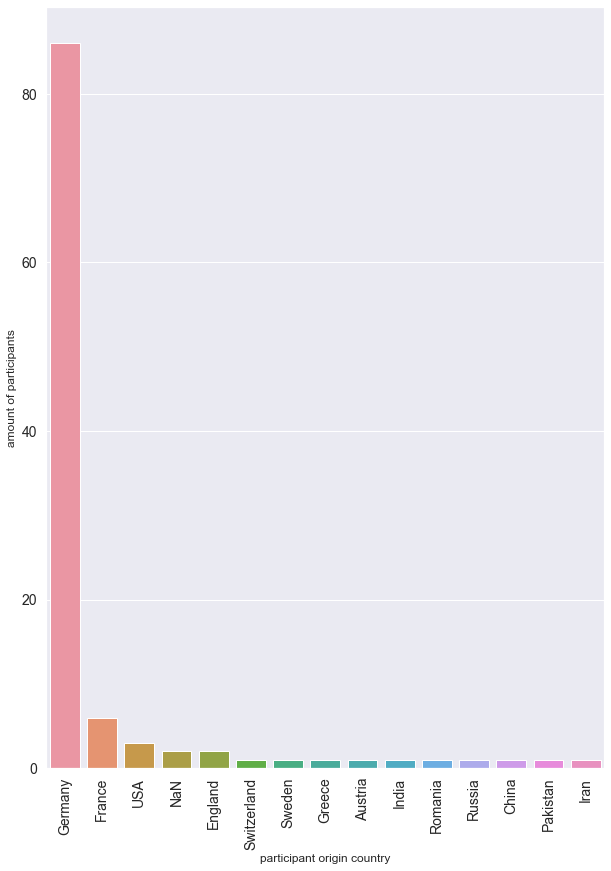

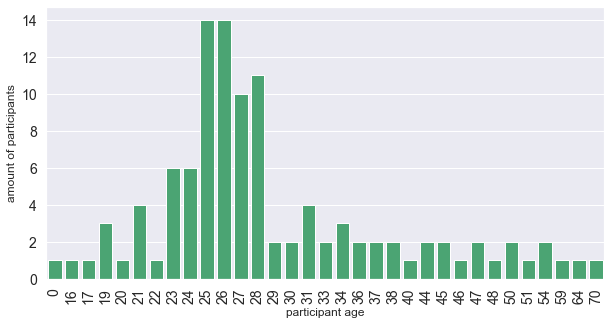

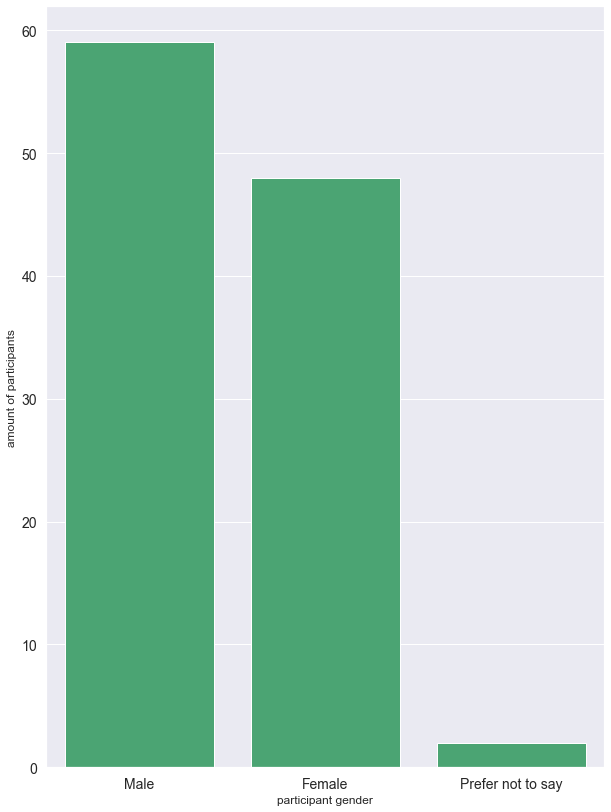

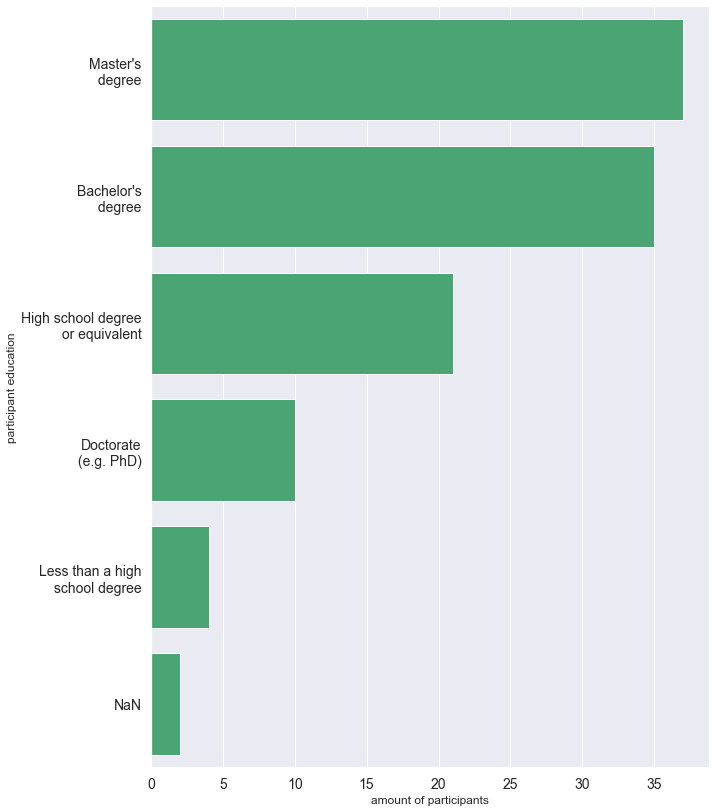

In [26]:
# Plot participant country of origin
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="p_country", data=df_plots, order = df_plots['p_country'].value_counts().index)
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);
#plt.yticks(rotation=90);
plt.tick_params(labelsize=14)
plt.xlabel('participant country of origin')
plt.ylabel('amount of participants')

plt.savefig('../plots/participant_origin_country.png', bbox_inches="tight")   # save the figure to file

# Plot participant age
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="p_age", data=df_plots, color='mediumseagreen')
sns.set(rc={'figure.figsize':(10, 14)})
plt.xticks(rotation=90);
plt.tick_params(labelsize=14)
plt.xlabel('participant age')
plt.ylabel('amount of participants')
#plt.legend(title='Legend', loc='upper right', labels=['NaN = age not specified'])

plt.savefig('../plots/participant_age.png', bbox_inches="tight")   # save the figure to file

# Plot participant gender
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="p_gender", data=df_plots, color='mediumseagreen', order = df_plots['p_gender'].value_counts().index)
sns.set(rc={'figure.figsize':(10, 14)})
#plt.xticks(rotation=90);
plt.tick_params(labelsize=14)
plt.xlabel('participant gender')
plt.ylabel('amount of participants')

plt.savefig('../plots/participant_gender.png', bbox_inches="tight")   # save the figure to file

# Plot participant education
plt.figure()
sns.set_theme(style="darkgrid")
ax = sns.countplot(y="p_education", data=df_plots, color='mediumseagreen', order = df_plots['p_education'].value_counts().index)
sns.set(rc={'figure.figsize':(10, 14)})
#plt.xticks(rotation=90);
plt.tick_params(labelsize=14)
plt.ylabel('participant education')
plt.xlabel('amount of participants')

plt.savefig('../plots/participant_education.png', bbox_inches="tight")   # save the figure to file

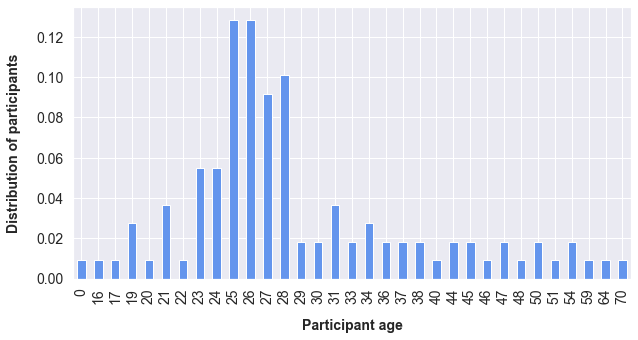

In [188]:
s_p_age = pd.Series(df_plots['p_age'])
s_p_age = s_p_age.sort_values(ascending=True)

s_p_age.value_counts(sort=False, normalize=True).plot(kind="bar", figsize=(10,5), color="cornflowerblue")
#s_p_age.value_counts(sort=False, normalize=True).plot(linewidth=3.0, figsize=(10,5), color="cornflowerblue")

plt.ylabel('Distribution of participants', fontsize=14,fontweight='bold', labelpad=15)
plt.xlabel('Participant age', fontsize=14,fontweight='bold', labelpad=15)
#plt.xticks(rotation=0)
plt.tick_params(labelsize=14)

plt.savefig('../plots/participant_age.png', bbox_inches="tight")   # save the figure to file

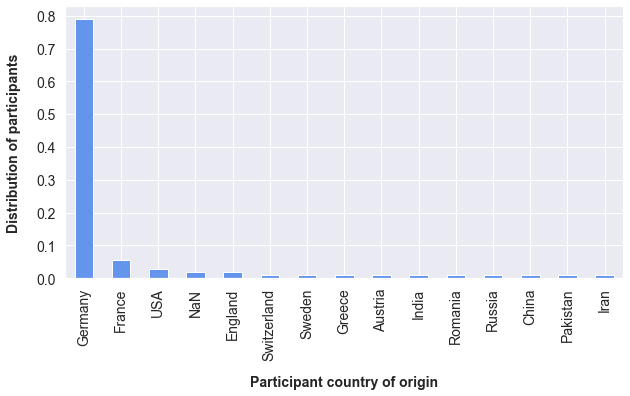

In [189]:
df_plots['p_country'].value_counts(normalize=True).plot(kind="bar", figsize=(10,5), color="cornflowerblue")
plt.ylabel('Distribution of participants', fontsize=14,fontweight='bold', labelpad=15)
plt.xlabel('Participant country of origin', fontsize=14,fontweight='bold', labelpad=15)
#plt.xticks(rotation=0)
plt.tick_params(labelsize=14)
#plt.grid(visible=None)

plt.savefig('../plots/participant_origin_country.png', bbox_inches="tight")   # save the figure to file

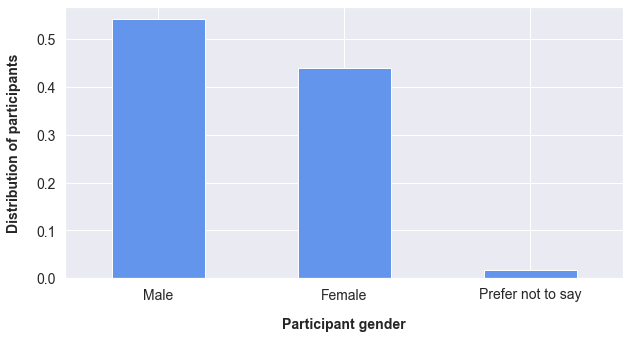

In [190]:
df_plots['p_gender'].value_counts(normalize=True).plot(kind="bar", figsize=(10,5), color="cornflowerblue")
#plt.pie(df_plots['p_gender'].value_counts(normalize=True))
plt.ylabel('Distribution of participants', fontsize=14,fontweight='bold', labelpad=15)
plt.xlabel('Participant gender', fontsize=14,fontweight='bold', labelpad=15)
plt.xticks(rotation=0)
plt.tick_params(labelsize=14)
#plt.grid(visible=None)

plt.savefig('../plots/participant_gender.png', bbox_inches="tight")   # save the figure to file

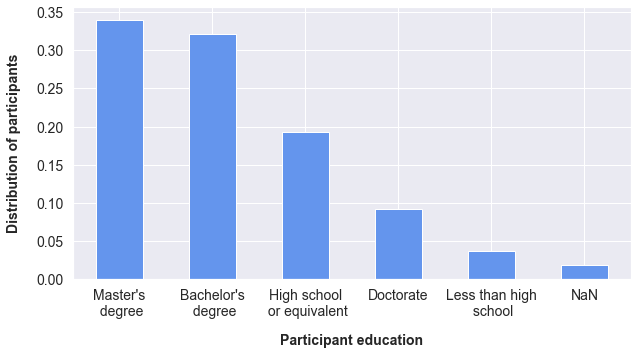

In [191]:
df_plots['p_education'].value_counts(normalize=True).plot(kind="bar", figsize=(10,5), color="cornflowerblue")
plt.ylabel('Distribution of participants', fontsize=14,fontweight='bold', labelpad=15)
plt.xlabel('Participant education', fontsize=14,fontweight='bold', labelpad=15)
plt.xticks(rotation=0);
plt.tick_params(labelsize=14)
#plt.grid(visible=None)

plt.savefig('../plots/participant_education.png', bbox_inches="tight")   # save the figure to file

## Category cleanup

### Split into single DataFrames per category

In [7]:
# Function for splitting(exploding) the comma-separated answers while keeping the demographic data of the survey participant (sex, age, education, country and p_id)

def exploder(data_frame, category_name_string):
    lst_col = category_name_string
    # build helper df consisting of the category + p (participant) columns
    helper_df = data_frame[[lst_col,'p_age','p_gender','p_education','p_country', 'p_id']].copy()
    
    # clean data by lowercasing, removing fault characters and whitespaces
    helper_df[lst_col] = helper_df[lst_col].str.lower()
    helper_df[lst_col] = helper_df[lst_col].replace('\/',',', regex=True).replace('\;',',', regex=True).replace('\?',',', regex=True).replace('\-',' ', regex=True).replace("'","", regex=True)#.replace('\ ','_', regex=True)
    
    # split category column after each comma and explode (= make a new row and duplicate the other column values for each element)    
    helper_df = helper_df.assign(**{lst_col:helper_df[lst_col].str.split(',')})
    helper_df = helper_df.explode(lst_col)
    helper_df[lst_col] = helper_df[lst_col].str.strip('\ ') # strip leading and trailing whitespace: https://docs.python.org/3/library/stdtypes.html

    return helper_df

In [8]:
# Get individual dataframes for each category consisting of the category values and all p-data
# + Reset index

df_nineties_movies = exploder(df, 'nineties_movies')
df_nineties_movies.reset_index(drop=True, inplace=True)

df_actors = exploder(df, 'actors')
df_actors.reset_index(drop=True, inplace=True)

df_music_genres = exploder(df, 'music_genres')
df_music_genres.reset_index(drop=True, inplace=True)

df_books = exploder(df, 'books')
df_books.reset_index(drop=True, inplace=True)

df_authors = exploder(df, 'authors')
df_authors.reset_index(drop=True, inplace=True)

df_politicians = exploder(df, 'politicians')
df_politicians.reset_index(drop=True, inplace=True)

df_us_presidents = exploder(df, 'us_presidents')
df_us_presidents.reset_index(drop=True, inplace=True)

df_cities = exploder(df, 'cities')
df_cities.reset_index(drop=True, inplace=True)

df_lakes = exploder(df, 'lakes')
df_lakes.reset_index(drop=True, inplace=True)

df_mountains = exploder(df, 'mountains')
df_mountains.reset_index(drop=True, inplace=True)

df_european_capital_cities = exploder(df, 'european_capital_cities')
df_european_capital_cities.reset_index(drop=True, inplace=True)

df_european_countries = exploder(df, 'european_countries')
df_european_countries.reset_index(drop=True, inplace=True)

df_asian_countries = exploder(df, 'asian_countries')
df_asian_countries.reset_index(drop=True, inplace=True)

df_continents = exploder(df, 'continents')
df_continents.reset_index(drop=True, inplace=True)

df_birds = exploder(df, 'birds')
df_birds.reset_index(drop=True, inplace=True)

df_african_animals = exploder(df, 'african_animals')
df_african_animals.reset_index(drop=True, inplace=True)

df_furniture = exploder(df, 'furniture')
df_furniture.reset_index(drop=True, inplace=True)

df_vegetables = exploder(df, 'vegetables')
df_vegetables.reset_index(drop=True, inplace=True)

df_fast_food = exploder(df, 'fast_food')
df_fast_food.reset_index(drop=True, inplace=True)

df_european_landmarks = exploder(df, 'european_landmarks')
df_european_landmarks.reset_index(drop=True, inplace=True)

df_dax_companies = exploder(df, 'dax_companies')
df_dax_companies.reset_index(drop=True, inplace=True)

df_us_companies = exploder(df, 'us_companies')
df_us_companies.reset_index(drop=True, inplace=True)

df_us_tech_companies = exploder(df, 'us_tech_companies')
df_us_tech_companies.reset_index(drop=True, inplace=True)

# Calculate the average amount of responses per category
amount_answers = (len(df_nineties_movies.index)+ len(df_actors.index)+ len(df_music_genres.index)+ len(df_books.index)+ len(df_authors.index)+ len(df_politicians.index)+ len(df_us_presidents.index)+ len(df_cities.index)+ len(df_lakes.index)+ len(df_mountains.index)+ len(df_european_capital_cities.index)+ len(df_european_countries.index)+ len(df_asian_countries.index)+ len(df_continents.index)+ len(df_birds.index)+ len(df_african_animals.index)+ len(df_furniture.index)+ len(df_vegetables.index)+ len(df_fast_food.index)+ len(df_european_landmarks.index)+ len(df_dax_companies.index)+ len(df_us_companies.index)+ len(df_us_tech_companies.index))/23
print('Average responses per category: '+ str(amount_answers))

Average responses per category: 314.7826086956522


### Translating answers into English

In [ ]:
# Function for translating the individual dataframes into English using the DeepL API (www.deepl.com)
# https://github.com/nidhaloff/deep-translator

from deep_translator import DeeplTranslator
# Deepl API Key = 86ed8cd0-6f1c-8ade-b1bb-9e934b24f98a:fx
# Check https://www.deepl.com/pro-account/usage for character usage left (max. of 500,000 characters per month)

def cat_translator(data_frame, category_name_string):
    helper_df = data_frame
    helper_series = data_frame[category_name_string].tolist()
    trans_list = DeeplTranslator("86ed8cd0-6f1c-8ade-b1bb-9e934b24f98a:fx").translate_batch(helper_series)
    helper_df[category_name_string] = trans_list
    return helper_df

In [ ]:
# translate
df_european_capital_cities_trans = cat_translator(df_european_capital_cities, 'european_capital_cities')

# save translated df as .csv-file because of the time and DeepL API constraints
df_european_capital_cities_trans.to_csv('../data/survey_single_cat_files/translated_df/df_european_capital_cities_trans.csv', sep=';', encoding='utf-8', index=False)
df_european_capital_cities_trans

In [ ]:
# translate
df_cities_trans = cat_translator(df_cities, 'cities')

# save translated df as .csv-file because of the time and DeepL API constraints
df_cities_trans.to_csv('../data/survey_single_cat_files/translated_df/df_cities_trans.csv', sep=';', encoding='utf-8', index=False)
df_cities_trans

In [ ]:
# translate
df_lakes_trans = cat_translator(df_lakes, 'lakes')

# save translated df as .csv-file because of the time and DeepL API constraints
df_lakes_trans.to_csv('../data/survey_single_cat_files/translated_df/df_lakes_trans.csv', sep=';', encoding='utf-8', index=False)
df_lakes_trans

In [ ]:
# translate
df_mountains_trans = cat_translator(df_mountains, 'mountains')

# save translated df as .csv-file because of the time and DeepL API constraints
df_mountains_trans.to_csv('../data/survey_single_cat_files/translated_df/df_mountains_trans.csv', sep=';', encoding='utf-8', index=False)
df_mountains_trans

In [ ]:
# translate
df_european_countries_trans = cat_translator(df_european_countries, 'european_countries')

# save translated df as .csv-file because of the time and DeepL API constraints
df_european_countries_trans.to_csv('../data/survey_single_cat_files/translated_df/df_european_countries_trans.csv', sep=';', encoding='utf-8', index=False)
df_european_countries_trans

In [ ]:
# translate
df_asian_countries_trans = cat_translator(df_asian_countries, 'asian_countries')

# save translated df as .csv-file because of the time and DeepL API constraints
df_asian_countries_trans.to_csv('../data/survey_single_cat_files/translated_df/df_asian_countries_trans.csv', sep=';', encoding='utf-8', index=False)
df_asian_countries_trans

In [ ]:
# translate
df_continents_trans = cat_translator(df_continents, 'continents')

# save translated df as .csv-file because of the time and DeepL API constraints
df_continents_trans.to_csv('../data/survey_single_cat_files/translated_df/df_continents_trans.csv', sep=';', encoding='utf-8', index=False)
df_continents_trans

In [ ]:
# translate
df_birds_trans = cat_translator(df_birds, 'birds')

# save translated df as .csv-file because of the time and DeepL API constraints
df_birds_trans.to_csv('../data/survey_single_cat_files/translated_df/df_birds_trans.csv', sep=';', encoding='utf-8', index=False)
df_birds_trans

In [ ]:
# translate
df_african_animals_trans = cat_translator(df_african_animals, 'african_animals')

# save translated df as .csv-file because of the time and DeepL API constraints
df_african_animals_trans.to_csv('../data/survey_single_cat_files/translated_df/df_african_animals_trans.csv', sep=';', encoding='utf-8', index=False)
df_african_animals_trans

In [ ]:
# translate
df_furniture_trans = cat_translator(df_furniture, 'furniture')

# save translated df as .csv-file because of the time and DeepL API constraints
df_furniture_trans.to_csv('../data/survey_single_cat_files/translated_df/df_furniture_trans.csv', sep=';', encoding='utf-8', index=False)
df_furniture_trans

In [ ]:
# translate
df_vegetables_trans = cat_translator(df_vegetables, 'vegetables')

# save translated df as .csv-file because of the time and DeepL API constraints
df_vegetables_trans.to_csv('../data/survey_single_cat_files/translated_df/df_vegetables_trans.csv', sep=';', encoding='utf-8', index=False)
df_vegetables_trans

In [ ]:
# translate
df_fast_food_trans = cat_translator(df_fast_food, 'fast_food')

# save translated df as .csv-file because of the time and DeepL API constraints
df_fast_food_trans.to_csv('../data/survey_single_cat_files/translated_df/df_fast_food_trans.csv', sep=';', encoding='utf-8', index=False)
df_fast_food_trans

In [ ]:
# translate
df_european_landmarks_trans = cat_translator(df_european_landmarks, 'european_landmarks')

# save translated df as .csv-file because of the time and DeepL API constraints
df_european_landmarks_trans.to_csv('../data/survey_single_cat_files/translated_df/df_european_landmarks_trans.csv', sep=';', encoding='utf-8', index=False)
df_european_landmarks_trans

### DBpedia URI lookup via API call

In [193]:
from urllib.request import urlopen
from urllib import parse
from Levenshtein import distance as levenshtein_distance


# Function for looking up the DBpedia URI and taking the one with the smallest Levenshtein distance to the search term
# API DBpedia lookup: https://github.com/dbpedia/dbpedia-lookup
# Levenshtein distance python package: https://pypi.org/project/python-Levenshtein/

def uriLookup(search):
    searchterm = parse.quote(str(search)) #parse to avoid ASCII/UTF-8 encoding conflicts within URL
    searchterm = searchterm.replace(' ', '%20')
    #raw_url = 'https://lookup.dbpedia.org/api/search?query=' + searchterm
    #encoded_url =  parse.quote(raw_url)
    lookup_url = urlopen('https://lookup.dbpedia.org/api/search?query=' + searchterm).read()
    tree = etree.fromstring(lookup_url)
    querylist  = []

    # Loop through the result set (bytestream containing XML) and append every link to a list
    for item in tree.iter():
        if item.tag == "URI":
            querylist.append(item.text.strip())

    # Create df from list
    df_uris = pd.DataFrame(querylist, columns =['uri'])
    df_uris['searchterm']=searchterm #add searchterm column that contains the searchterm in each row
    
    # Compute Levenshtein Distance between result URIs and search term and return URI with the smallest
    # --> atm not used as the results where worse than without
    #df_uris['lsd'] = df_uris.apply(lambda row: levenshtein_distance(row['uri'], row['searchterm']), axis=1)
    #df_uris = df_uris.sort_values('lsd')#.reset_index()
    
    try:
        df_uris.iloc[0]
    except IndexError:
        return 'NaN'
    
    uri_return = df_uris['uri'].iloc[0]
    uri_return
    return uri_return


# Function for incorporating the uriLookup result into the DataFrame
# takes goal DF and string of the category column name as input

def uriMerge(df_input, search_col):
    lookup_df = df_input
    lookup_df['uri'] = pd.Series([uriLookup(term) for term in lookup_df[search_col]])
    lookup_df
    return lookup_df

In [194]:
# test
print('http://dbpedia.org/resource/B36_Tórshavn:', levenshtein_distance('http://dbpedia.org/resource/B36_Tórshavn', 'torshavn'))
print('http://dbpedia.org/resource/Tórshavn:', levenshtein_distance('http://dbpedia.org/resource/Tórshavn', 'torshavn'))

http://dbpedia.org/resource/B36_Tórshavn: 32
http://dbpedia.org/resource/Tórshavn: 28


In [ ]:
# load translated categories because of the computing time and DeepL API constraints

df_european_capital_cities = pd.read_csv('../data/survey_single_cat_files/translated_df/df_european_capital_cities_trans.csv', sep=';')
#df_european_capital_cities = df_european_capital_cities['european_capital_cities'].replace('\ ','_', regex=True)

df_cities = pd.read_csv('../data/survey_single_cat_files/translated_df/df_cities_trans.csv', sep=';')
#df_cities = df_cities['cities'].replace('\ ','_', regex=True)

df_lakes = pd.read_csv('../data/survey_single_cat_files/translated_df/df_lakes_trans.csv', sep=';')
#df_lakes = df_lakes['lakes'].replace('\ ','_', regex=True)

df_mountains = pd.read_csv('../data/survey_single_cat_files/translated_df/df_mountains_trans.csv', sep=';')
#df_mountains = df_mountains['mountains'].replace('\ ','_', regex=True)

df_european_countries = pd.read_csv('../data/survey_single_cat_files/translated_df/df_european_countries_trans.csv', sep=';')
#df_european_countries = df_european_countries['european_countries'].replace('\ ','_', regex=True)

df_asian_countries = pd.read_csv('../data/survey_single_cat_files/translated_df/df_asian_countries_trans.csv', sep=';')
#df_asian_countries = df_asian_countries['asian_countries'].replace('\ ','_', regex=True)

df_continents = pd.read_csv('../data/survey_single_cat_files/translated_df/df_continents_trans.csv', sep=';')
#df_continents = df_continents['continents'].replace('\ ','_', regex=True)

df_birds = pd.read_csv('../data/survey_single_cat_files/translated_df/df_birds_trans.csv', sep=';')
#df_birds = df_birds['birds'].replace('\ ','_', regex=True)

df_african_animals = pd.read_csv('../data/survey_single_cat_files/translated_df/df_african_animals_trans.csv', sep=';')
#df_african_animals = df_african_animals['african_animals'].replace('\ ','_', regex=True)

df_furniture = pd.read_csv('../data/survey_single_cat_files/translated_df/df_furniture_trans.csv', sep=';')
#df_furniture = df_furniture['furniture'].replace('\ ','_', regex=True)

df_vegetables = pd.read_csv('../data/survey_single_cat_files/translated_df/df_vegetables_trans.csv', sep=';')
#df_vegetables = df_vegetables['vegetables'].replace('\ ','_', regex=True)

df_fast_food = pd.read_csv('../data/survey_single_cat_files/translated_df/df_fast_food_trans.csv', sep=';')
#df_fast_food = df_fast_food['fast_food'].replace('\ ','_', regex=True)

df_european_landmarks = pd.read_csv('../data/survey_single_cat_files/translated_df/df_european_landmarks_trans.csv', sep=';')
#df_european_landmarks = df_european_landmarks['european_landmarks'].replace('\ ','_', regex=True)

In [ ]:
%%time

df_nineties_movies_prep = uriMerge(df_nineties_movies, 'nineties_movies')
#df_nineties_movies.reset_index(drop=True, inplace=True)
df_nineties_movies_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_film90_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_actors_prep = uriMerge(df_actors, 'actors')
#df_actors.reset_index(drop=True, inplace=True)
df_actors_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_actors_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_music_genres_prep = uriMerge(df_music_genres, 'music_genres')
#df_music_genres.reset_index(drop=True, inplace=True)
df_music_genres_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_music_genres_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_books_prep = uriMerge(df_books, 'books')
#df_books.reset_index(drop=True, inplace=True)
df_books_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_books_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_authors_prep = uriMerge(df_authors, 'authors')
#df_authors.reset_index(drop=True, inplace=True)
df_authors_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_authors_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_politicians_prep = uriMerge(df_politicians, 'politicians')
#df_politicians.reset_index(drop=True, inplace=True)
df_politicians_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_politicians_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_us_presidents_prep = uriMerge(df_us_presidents, 'us_presidents')
#df_us_presidents.reset_index(drop=True, inplace=True)
df_us_presidents_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_potus_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_cities_prep = uriMerge(df_cities, 'cities')
#df_cities.reset_index(drop=True, inplace=True)
df_cities_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_cities_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_lakes_prep = uriMerge(df_lakes, 'lakes')
#df_lakes.reset_index(drop=True, inplace=True)
df_lakes_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_lakes_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_mountains_prep = uriMerge(df_mountains, 'mountains')
#df_mountains.reset_index(drop=True, inplace=True)
df_mountains_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_mountains_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_european_capital_cities_prep = uriMerge(df_european_capital_cities, 'european_capital_cities')
#df_european_capital_cities.reset_index(drop=True, inplace=True)
df_european_capital_cities_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_european_capital_cities_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_european_countries_prep = uriMerge(df_european_countries, 'european_countries')
#df_european_countries.reset_index(drop=True, inplace=True)
df_european_countries_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_european_countries_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_asian_countries_prep = uriMerge(df_asian_countries, 'asian_countries')
#df_asian_countries.reset_index(drop=True, inplace=True)
df_asian_countries_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_asian_countries_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_continents_prep = uriMerge(df_continents, 'continents')
#df_continents.reset_index(drop=True, inplace=True)
df_continents_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_continents_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_birds_prep = uriMerge(df_birds, 'birds')
#df_birds.reset_index(drop=True, inplace=True)
df_birds_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_birds_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_african_animals_prep = uriMerge(df_african_animals, 'african_animals')
#df_african_animals.reset_index(drop=True, inplace=True)
df_african_animals_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_african_animals_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_furniture_prep = uriMerge(df_furniture, 'furniture')
#df_furniture.reset_index(drop=True, inplace=True)
df_furniture_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_furniture_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_vegetables_prep = uriMerge(df_vegetables, 'vegetables')
#df_vegetables.reset_index(drop=True, inplace=True)
df_vegetables_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_vegetables_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_fast_food_prep = uriMerge(df_fast_food, 'fast_food')
#df_fast_food.reset_index(drop=True, inplace=True)
df_fast_food_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_fast_food_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_european_landmarks_prep = uriMerge(df_european_landmarks, 'european_landmarks')
#df_european_landmarks.reset_index(drop=True, inplace=True)
df_european_landmarks_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_european_landmarks_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_dax_companies_prep = uriMerge(df_dax_companies, 'dax_companies')
#df_dax_companies.reset_index(drop=True, inplace=True)
df_dax_companies_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_dax_companies_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_us_companies_prep = uriMerge(df_us_companies, 'us_companies')
#df_us_companies.reset_index(drop=True, inplace=True)
df_us_companies_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_us_companies_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
%%time

df_us_tech_companies_prep = uriMerge(df_us_tech_companies, 'us_tech_companies')
#df_us_tech_companies.reset_index(drop=True, inplace=True)
df_us_tech_companies_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_us_tech_companies_prep.csv', sep=';', encoding='utf-8', index=False)

In [ ]:
# Whole block for merging instead of single cells


df_nineties_movies_prep = uriMerge(df_nineties_movies, 'nineties_movies')
#df_nineties_movies.reset_index(drop=True, inplace=True)

df_actors_prep = uriMerge(df_actors, 'actors')
#df_actors.reset_index(drop=True, inplace=True)

df_music_genres_prep = uriMerge(df_music_genres, 'music_genres')
#df_music_genres.reset_index(drop=True, inplace=True)

df_books_prep = uriMerge(df_books, 'books')
#df_books.reset_index(drop=True, inplace=True)

df_authors_prep = uriMerge(df_authors, 'authors')
#df_authors.reset_index(drop=True, inplace=True)

df_politicians_prep = uriMerge(df_politicians, 'politicians')
#df_politicians.reset_index(drop=True, inplace=True)

df_us_presidents_prep = uriMerge(df_us_presidents, 'us_presidents')
#df_us_presidents.reset_index(drop=True, inplace=True)

df_cities_prep = uriMerge(df_cities, 'cities')
#df_cities.reset_index(drop=True, inplace=True)

df_lakes_prep = uriMerge(df_lakes, 'lakes')
#df_lakes.reset_index(drop=True, inplace=True)

df_mountains_prep = uriMerge(df_mountains, 'mountains')
#df_mountains.reset_index(drop=True, inplace=True)

df_european_capital_cities_prep = uriMerge(df_european_capital_cities, 'european_capital_cities')
#df_european_capital_cities.reset_index(drop=True, inplace=True)

df_european_countries_prep = uriMerge(df_european_countries, 'european_countries')
#df_european_countries.reset_index(drop=True, inplace=True)

df_asian_countries_prep = uriMerge(df_asian_countries, 'asian_countries')
#df_asian_countries.reset_index(drop=True, inplace=True)

df_continents_prep = uriMerge(df_continents, 'continents')
#df_continents.reset_index(drop=True, inplace=True)

df_birds_prep = uriMerge(df_birds, 'birds')
#df_birds.reset_index(drop=True, inplace=True)

df_african_animals_prep = uriMerge(df_african_animals, 'african_animals')
#df_african_animals.reset_index(drop=True, inplace=True)

df_furniture_prep = uriMerge(df_furniture, 'furniture')
#df_furniture.reset_index(drop=True, inplace=True)

df_vegetables_prep = uriMerge(df_vegetables, 'vegetables')
#df_vegetables.reset_index(drop=True, inplace=True)

df_fast_food_prep = uriMerge(df_fast_food, 'fast_food')
#df_fast_food.reset_index(drop=True, inplace=True)

df_european_landmarks_prep = uriMerge(df_european_landmarks, 'european_landmarks')
#df_european_landmarks.reset_index(drop=True, inplace=True)

df_dax_companies_prep = uriMerge(df_dax_companies, 'dax_companies')
#df_dax_companies.reset_index(drop=True, inplace=True)

df_us_companies_prep = uriMerge(df_us_companies, 'us_companies')
#df_us_companies.reset_index(drop=True, inplace=True)

df_us_tech_companies_prep = uriMerge(df_us_tech_companies, 'us_tech_companies')
#df_us_tech_companies.reset_index(drop=True, inplace=True)

### Export category DataFrames

In [ ]:
# create single .csv-files per translated category
df_european_capital_cities_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_european_capital_cities_prep.csv', sep=';', encoding='utf-8', index=False)
df_lakes_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_lakes_prep.csv', sep=';', encoding='utf-8', index=False)
df_mountains_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_mountains_prep.csv', sep=';', encoding='utf-8', index=False)
df_european_countries_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_european_countries_prep.csv', sep=';', encoding='utf-8', index=False)
df_asian_countries_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_asian_countries_prep.csv', sep=';', encoding='utf-8', index=False)
df_continents_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_continents_prep.csv', sep=';', encoding='utf-8', index=False)
df_birds_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_birds_prep.csv', sep=';', encoding='utf-8', index=False)
df_african_animals_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_african_animals_prep.csv', sep=';', encoding='utf-8', index=False)
df_furniture_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_furniture_prep.csv', sep=';', encoding='utf-8', index=False)
df_vegetables_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_vegetables_prep.csv', sep=';', encoding='utf-8', index=False)
df_fast_food_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_fast_food_prep.csv', sep=';', encoding='utf-8', index=False)
df_european_landmarks_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_european_landmarks_prep.csv', sep=';', encoding='utf-8', index=False)
df_cities_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_cities_prep.csv', sep=';', encoding='utf-8', index=False)

# create single .csv-files per category that where not translated
df_nineties_movies_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_film90_prep.csv', sep=';', encoding='utf-8', index=False)
df_actors_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_actors_prep.csv', sep=';', encoding='utf-8', index=False)
df_music_genres_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_music_genres_prep.csv', sep=';', encoding='utf-8', index=False)
df_books_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_books_prep.csv', sep=';', encoding='utf-8', index=False)
df_authors_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_authors_prep.csv', sep=';', encoding='utf-8', index=False)
df_politicians_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_politicians_prep.csv', sep=';', encoding='utf-8', index=False)
df_us_presidents_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_potus_prep.csv', sep=';', encoding='utf-8', index=False)
df_dax_companies_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_dax_companies_prep.csv', sep=';', encoding='utf-8', index=False)
df_us_companies_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_us_companies_prep.csv', sep=';', encoding='utf-8', index=False)
df_us_tech_companies_prep.to_csv('../data/survey_single_cat_files/sv_prep_uri/sv_us_tech_companies_prep.csv', sep=';', encoding='utf-8', index=False)

## Other

### REST API call KG2vec

In [ ]:
response = requests.get("http://kgvec2go.org/rest/get-vector/dbpedia/Berlin")
print(response)

In [ ]:
response.content # Return the raw bytes of the data payload
#response.text # Return a string representation of the data payload
#response.json # This method is convenient when the API returns JSON

In [ ]:
response.json()